In [1]:

import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [2]:
record_path=r"C:\Users\piotr\.cache\kagglehub\datasets\nih-chest-xrays\data\versions\3"
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)

In [3]:
# We load up the csv with all the data.
df=pd.read_csv(record_path+r"\Data_Entry_2017.csv")
good=["Image Index","Finding Labels"]
df=df[good]
df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


In [4]:
# Getting all the deseases from the DF and creating one-hot encoding.
diseases=set()
for findings in df["Finding Labels"].unique():
    for disease_label in findings.split("|"):
        diseases.add(disease_label)
for d in diseases:
    df[d]=0
for index,row in df.iterrows():
    labels= row["Finding Labels"].split("|")
    for i in labels:
        df.loc[index,i]=1
df=df.drop("Finding Labels",axis=1)
df.head()

,Image Index,Pneumothorax,No Finding,Cardiomegaly,Fibrosis,Mass,Atelectasis,Nodule,Edema,Consolidation,Pleural_Thickening,Effusion,Hernia,Emphysema,Infiltration,Pneumonia
0,00000001_000.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,00000001_002.png,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,00000002_000.png,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


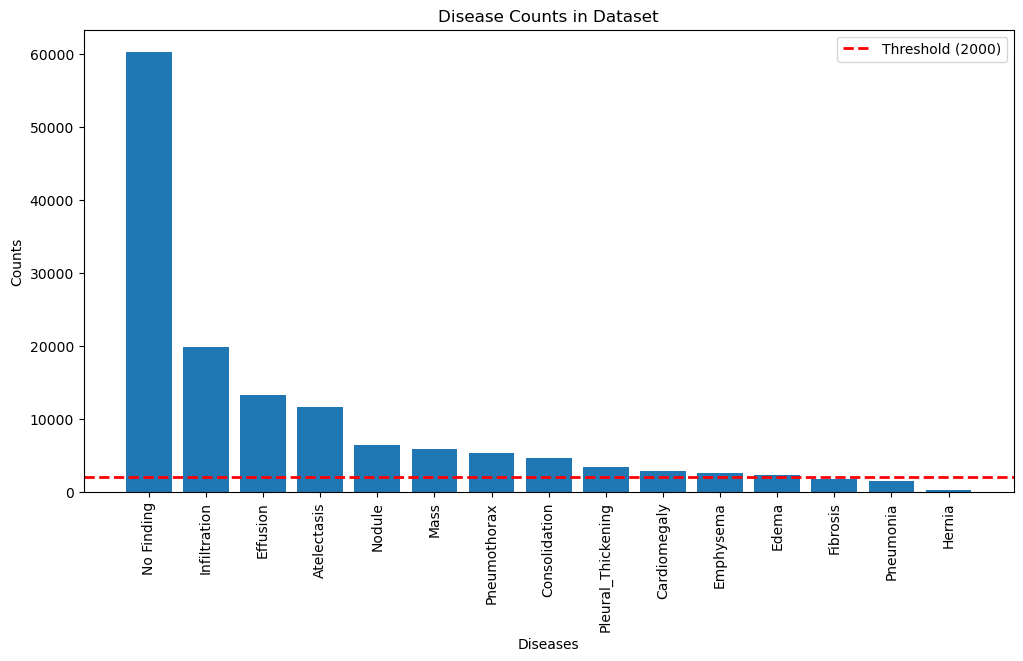

In [5]:
#We visualize the distribution of all the diseases
counts=[df[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [ ]:
# we now create the training dataframe using the list provided in the files.
image_names_train= open(r"train_val_list.txt").read().split("\n")
for i in image_names_train:
    df_train=df[df["Image Index"].isin(image_names_train)]
# we now create the testing dataframe using the list provided in the files.
image_names_test= open(r"test_list.txt").read().split("\n")
for i in image_names_test:
    df_test=df[df["Image Index"].isin(image_names_test)]

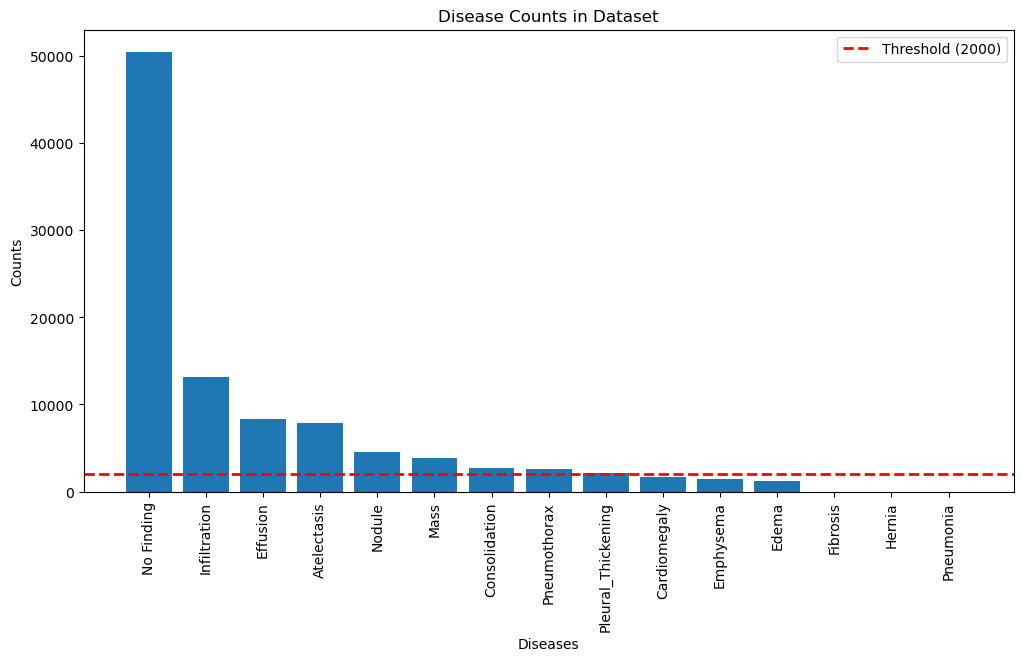

In [7]:
# we now look at the training data
df_train=pd.read_parquet("df_train.parquet")
# We check to see how balanced the set is and check if any class is very underrepresented.
counts=[df_train[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [8]:
# As we can see the training data already removed the most rare diseases. However we still remove all the diseases that have less than 2000 cases.
# we remove diseases that are too rare.
rare_diseases=[d[0] for d in disease_counts if d[1]<2000]
print("Rare Diseases ( <2000 images ): ", rare_diseases)
for disease in rare_diseases:
    df_train=df_train[df_train[disease] !=1]
df_train=df_train[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
df_train=df_train.drop(columns="No Finding")

Rare Diseases ( <2000 images ):  ['Cardiomegaly', 'Emphysema', 'Edema', 'Fibrosis', 'Hernia', 'Pneumonia']


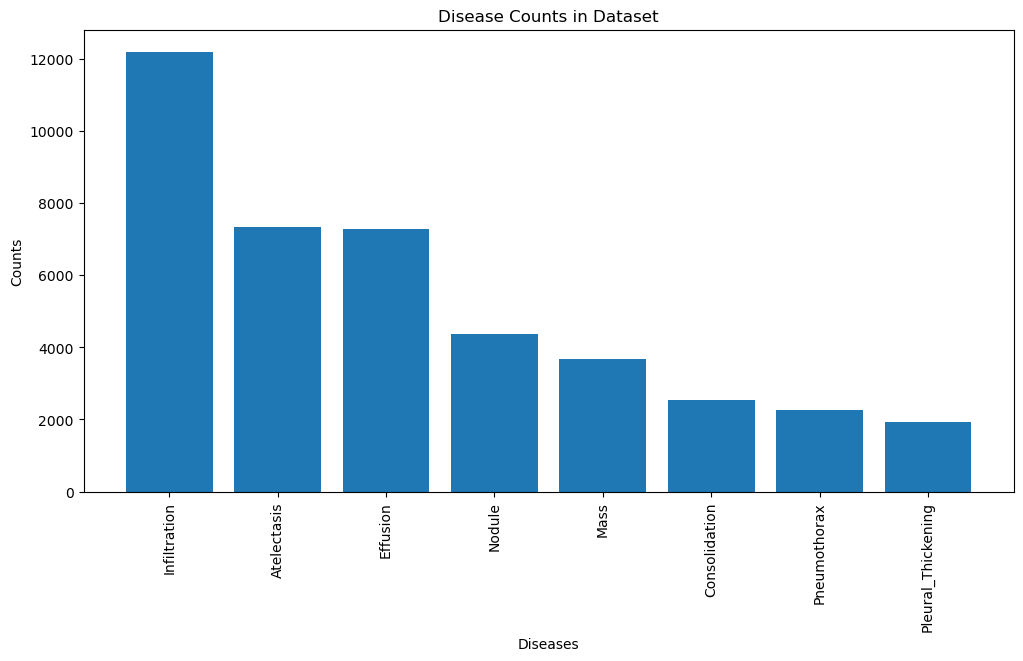

In [9]:
#Sanity check plot
disease_in_train=df_train.columns.tolist()[1:]
counts=[df_train[d].sum() for d in disease_in_train]
disease_counts = sorted(zip(disease_in_train, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.show()

In [10]:
#our data is now cleaned and we save it.
df_train.to_parquet("df_train_cleaned.parquet")

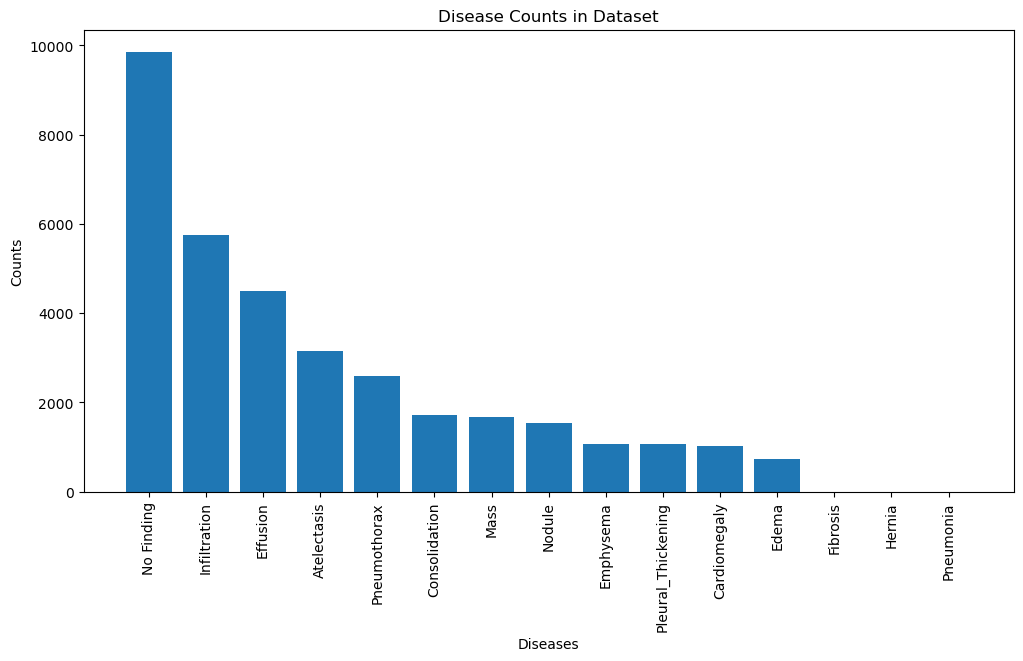

In [11]:
#We now repeat all the steps for the training data
# we now look at the training data
df_test=pd.read_parquet("df_test.parquet")
# We check to see how balanced the set is and check if any class is very underrepresented.
counts=[df_test[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.show()

In [12]:
#We remove the same diseases that we have removed for the training data and save the cleaned test.
for disease in rare_diseases:
    df_test=df_test[df_test[disease] !=1]
df_test=df_test[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
df_test=df_test.drop(columns="No Finding")

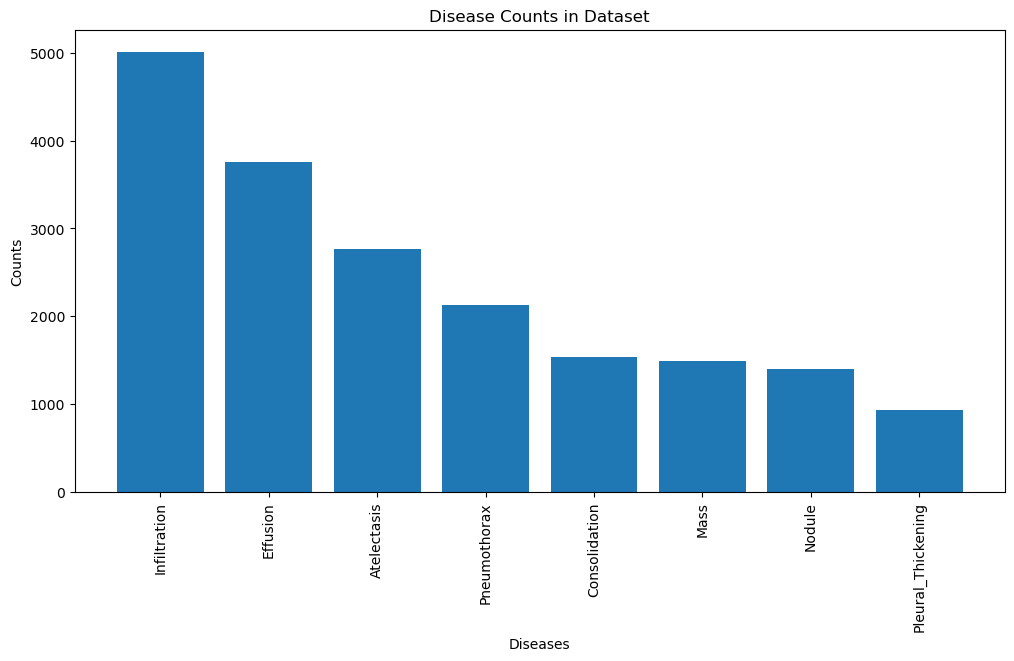

In [13]:
#Sanity check plot
disease_in_test=df_test.columns.tolist()[1:]
counts=[df_test[d].sum() for d in disease_in_test]
disease_counts = sorted(zip(disease_in_test, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.show()

In [14]:
df_test.to_parquet("df_test_cleaned.parquet")